In [ ]:
""" Compare redfield with normal rates."""

import pickle
from datetime import datetime
import numpy as np
from qutip import *
import os
from matplotlib import pyplot as plt
import sys
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks, welch, butter, filtfilt


def lindblad_master_equation(t, rho_vec, hamiltonian, L_operators):
    d = int(len(rho_vec)**.5)
    rho = rho_vec.reshape(d, d)

    L_conj = np.conj(L_operators)

    term1 = np.einsum('nij, jk, nlk', L_operators, rho, L_conj)
    term2 = np.einsum('nji, njk, kl', L_conj, L_operators, rho)
    term3 = np.einsum('ij, nkj, nkl', rho, L_conj, L_operators)

    lindblad_part = term1 - .5*(term2 + term3)

    coherent_part = -1j*(np.einsum('ij,jk',hamiltonian, rho) - np.einsum('ij,jk', rho, hamiltonian))

    drho = coherent_part + lindblad_part
    return drho.flatten()

def calculate_full_dynamics(parameters):
    
    #Retrieve needed parameters from the dictionary.
    N = parameters['N']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']
    final_time__mus = parameters['final_time__mus'] 
    time_steps = parameters["time_steps"]
    psi0_atom = parameters['initial_state_qubit']

    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
    cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)
    tlist = np.linspace(0, final_time__mus, time_steps)/(10**6)

    #Norm everything
    tlist__N = tlist*norm
    cavity_detuning__N = cavity_detuning/norm
    cavity_drive_amplitude__N = cavity_drive_amplitude/norm
    qubit_detuning__N = qubit_detuning/norm
    eff_coupling__N = eff_coupling/norm
    rabi_freq__N = rabi_freq/norm
    cavity_diss_rate__N = cavity_diss_rate/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm

    ### HAMILTONIAN 7 ####
    d = tensor(destroy(N), qeye(2))   
    sz = tensor(qeye(N), sigmaz())  
    sx = tensor(qeye(N), sigmax())     
    sm = tensor(qeye(N), sigmam()) 

    H_cav = cavity_detuning__N * d.dag()*d + cavity_drive_amplitude__N * (d + d.dag())
    H_qubit = .5*(qubit_detuning__N + eff_coupling__N)*sz + .5*rabi_freq__N*sx
    H_int =   eff_coupling__N*d.dag()*d*sz
    H = H_cav + H_qubit + H_int

    H_matrix = H.full()
    d_matrix = d.full()


    dissipation_channels = [(cavity_diss_rate__N**.5*d_matrix)]

    psi0_cavity = coherent(N,cavity_field)
    initial_state = tensor(psi0_cavity, psi0_atom)
    rho0 = initial_state@initial_state.dag()
    rho0_matrix = rho0.full()
    rho0_vectorized = rho0_matrix.flatten()

    max_step =  0.05/np.max([cavity_drive_amplitude__N, qubit_detuning__N, cavity_detuning__N,
                            rabi_freq__N, eff_coupling__N, cavity_diss_rate__N])

    sol = solve_ivp(lindblad_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                     t_eval=tlist__N, max_step=max_step, args=(H_matrix, dissipation_channels))

    full_dynamics = sol.y.T.reshape(time_steps, 2*N, 2*N)

    dynamics = [Qobj(i, dims=[[N, 2], [N, 2]]) for i in full_dynamics]

    return dynamics

def target_hamiltonian(parameters):

    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']

    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
    rabi_freq__N = rabi_freq/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm

    H_qubit_target = .5*(qubit_detuning_lamb_shift__N*sigmaz() + rabi_freq__N*sigmax())
    return H_qubit_target

def unitary_diag_qubit_hamiltonian(parameters):
    """
    Returns U = exp(i * θ/2 * σ_y) that diagonlizes the qubit Hamiltonian
    """

    #Retrieve needed parameters from the dictionary.
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']


    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)

    theta = np.arctan2(rabi_freq, qubit_detuning_lamb_shift)

    U = (1j * theta/2 * sigmay()).expm()

    return U


def save_full_dynamics(dynamics_data, save_dir="./saved_dynamics"):
    """
    Save all four types of dynamics along with parameters
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Create timestamp for unique filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Prepare data to save
    data_to_save = {
        'full_dynamics': dynamics_data['full_dynamics'], 
        'parameters': dynamics_data['parameters'],
        'timestamp': timestamp,
        'description': "Full-dynamics sweep data"
    }
    
    # Add specific parameter value to filename based on what's being swept
    if 'eff_coupling_MHz' in dynamics_data:
        param_value = dynamics_data['eff_coupling_MHz']
        filename = f"eff_coupling_{param_value:.1f}MHz_{timestamp}.pkl"
        data_to_save['description'] = f"Full-dynamics for eff_coupling={param_value}MHz"
    elif 'cavity_diss_rate_MHz' in dynamics_data:
        param_value = dynamics_data['cavity_diss_rate_MHz']
        filename = f"kappa_{param_value:.1f}MHz_{timestamp}.pkl"
        data_to_save['description'] = f"Full-dynamics for kappa={param_value}MHz"
    else:
        filename = f"dynamics_{timestamp}.pkl"
    
    filepath = os.path.join(save_dir, filename)
    
    with open(filepath, 'wb') as f:
        pickle.dump(data_to_save, f)
    
    print(f"  All dynamics saved to: {filepath}", flush=True)
    return filepath


def load_all_dynamics(filepath):
    """
    Load multi-dynamics from saved file (now includes time-dependent Redfield)
    """
    with open(filepath, 'rb') as f:
        loaded_data = pickle.load(f)
    
    print(f"Multi-dynamics loaded from: {filepath}", flush=True)
    print(f"Description: {loaded_data['description']}", flush=True)
    print(f"Timestamp: {loaded_data['timestamp']}", flush=True)
    
    # Return all four dynamics types
    return (loaded_data['full_dynamics'], 
            loaded_data['parameters'])



def plot_dynamics_comparison(tlist, dynamics_dict, params_text, N, max_time=None):
    """
    Plot comparison of different dynamics methods
    
    Parameters:
    tlist: time array
    dynamics_dict: dictionary with keys and corresponding dynamics objects
                  e.g., {'Hamiltonian 7': full_dynamics, 'Redfield': redfield_dynamics, ...}
    max_time: maximum time to plot (uses max(tlist) if None)
    """
    
    # Determine time range to plot
    if max_time is None:
        max_time = max(tlist)
    
    time_mask = tlist <= max_time
    tlist_plot = tlist[time_mask]
    
    # Create plot - now 3 subplots instead of 2
    fig, axes = plt.subplots(3, 1, figsize=(4, 8))
    
    # Define colors for different methods
    colors = {
        'Hamiltonian 7': '#000080',
        'Redfield': '#008000', 
        'Rates': '#800000',
        'Time-dep Redfield': '#FFA500'
    }
    
    # Plot each method
    for label, dynamics in dynamics_dict.items():
        color = colors.get(label, None)
        
        # Calculate expectations (handle both system and combined Hilbert spaces)
        if hasattr(dynamics[0], 'dims') and dynamics[0].dims == [[N,2],[N,2]]:
            # Combined Hilbert space (cavity + qubit)
            x_exp = expect(tensor(qeye(N), sigmax()), dynamics)
            z_exp = expect(tensor(qeye(N), sigmaz()), dynamics)
            # Calculate cavity photon number expectation
            cavity_number_op = tensor(destroy(N).dag() * destroy(N), qeye(2))
            cavity_exp = expect(cavity_number_op, dynamics)
        else:
            # Qubit only - no cavity information available
            x_exp = expect(sigmax(), dynamics)
            z_exp = expect(sigmaz(), dynamics)
            cavity_exp = np.zeros_like(x_exp)  # Placeholder
        
        # Plot qubit expectations
        axes[0].plot(tlist_plot, x_exp[time_mask], color=color, label=label)
        axes[1].plot(tlist_plot, z_exp[time_mask], color=color, label=label)
        
        # Plot cavity photon number (only for methods with cavity information)
        if hasattr(dynamics[0], 'dims') and dynamics[0].dims == [[N,2],[N,2]]:
            axes[2].plot(tlist_plot, cavity_exp[time_mask], color=color, label=label)
    
    # Format σ_x plot
    axes[0].set_ylabel(r'$\langle\sigma_x\rangle$')
    axes[0].legend(fontsize=8)
    axes[0].set_ylim(-1.1, 1.1)
    axes[0].grid(True, alpha=0.3)
    
    # Format σ_z plot  
    axes[1].set_ylabel(r'$\langle\sigma_z\rangle$')
    axes[1].legend(fontsize=8)
    axes[1].set_ylim(-1.1, 1.1)
    axes[1].grid(True, alpha=0.3)
    
    # Format cavity photon number plot
    axes[2].set_ylabel(r'$\langle a^\dagger a \rangle$')
    axes[2].set_xlabel('Time (μs)')
    axes[2].legend(fontsize=8)
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle(' | '.join(params_text), y=0.98)
    plt.tight_layout()
    
    return fig, axes





def plot_and_save(filepath, save_dir="./plots0_5", max_time=None):
    """
    Load a saved dynamics file and plot comparison between Redfield and Lindblad (normal) dynamics.
    """

    # Load data
    full_dynamics, parameters = load_all_dynamics(filepath)
    N = parameters['N']
    time_steps = parameters['time_steps']
    final_time__mus = parameters['final_time__mus']

    # Time axis (in microseconds)
    tlist = np.linspace(0, final_time__mus, time_steps)

    # For comparison: here you can add Redfield results if you have them loaded separately
    # e.g., redfield_dynamics = ...
    # For now, we'll just plot the saved full_dynamics (Lindblad) version
    dynamics_dict = {"Normal rates": full_dynamics}

    # Format parameters text for the title
    params_text = [
        f"Rabi: {parameters['rabi_freq']/(2*np.pi*1e6):.1f} MHz",
        f"κ: {parameters['cavity_diss_rate']/(2*np.pi*1e6):.1f} MHz",
        r"$\chi$: " + f"{parameters['eff_coupling']/(2*np.pi*1e6):.1f} MHz",
    ]

    # === Plot σ_x, σ_z, and photon number ===
    fig, axes = plt.subplots(3, 1, figsize=(4, 8))

    x_exp = expect(tensor(qeye(N), sigmax()), full_dynamics)
    z_exp = expect(tensor(qeye(N), sigmaz()), full_dynamics)
    cavity_number_op = tensor(destroy(N).dag() * destroy(N), qeye(2))
    cavity_exp = expect(cavity_number_op, full_dynamics)

    if max_time is None:
        max_time = final_time__mus
    mask = tlist <= max_time

    axes[0].plot(tlist[mask], x_exp[mask], color='navy', label='Normal rates')
    axes[0].set_ylabel(r'$\langle\sigma_x\rangle$')
    axes[0].legend(fontsize=8)
    axes[0].grid(alpha=0.3)

    axes[1].plot(tlist[mask], z_exp[mask], color='darkred', label='Normal rates')
    axes[1].set_ylabel(r'$\langle\sigma_z\rangle$')
    axes[1].legend(fontsize=8)
    axes[1].grid(alpha=0.3)

    axes[2].plot(tlist[mask], cavity_exp[mask], color='darkgreen', label='Photon number')
    axes[2].set_ylabel(r'$\langle a^\dagger a \rangle$')
    axes[2].set_xlabel("Time (μs)")
    axes[2].grid(alpha=0.3)

    plt.suptitle(" | ".join(params_text))
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # === Save figure ===
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    fig_name = f"comparison_plot_eff_coupling_{parameters['eff_coupling']:.1f}MHz__{timestamp}.png"
    fig_path = os.path.join(save_dir, fig_name)
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")

    print(f"✓ Saved plot to: {fig_path}")
    plt.close(fig)

    dominant_freq, period = analyze_sigma_x_oscillations(tlist[mask], x_exp[mask],
                                                     save_dir="./plots_fft_kappa0_5",
                                                     label="Full dynamics")

    return parameters['eff_coupling'], dominant_freq



def analyze_sigma_x_oscillations(tlist, x_exp, save_dir="./plots_fft", label="Normal rates", 
                                min_freq_MHz=0.1, max_freq_MHz=50.0):
    """
    Improved version with better frequency analysis
    """

    
    os.makedirs(save_dir, exist_ok=True)

    # === Preprocessing ===
    t = np.array(tlist)
    y = np.array(x_exp)
    
    # Remove potential linear trend
    if len(t) > 1:
        coeffs = np.polyfit(t, y, 1)
        trend = np.polyval(coeffs, t)
        y_detrended = y - trend
    else:
        y_detrended = y
    
    # Apply windowing to reduce spectral leakage
    window = np.hanning(len(y_detrended))
    y_windowed = y_detrended * window
    
    dt = np.mean(np.diff(t))
    fs = 1.0 / dt  # sampling frequency in MHz
    
    # === Method 1: FFT with better peak detection ===
    N = len(y_windowed)
    freqs = np.fft.rfftfreq(N, dt)
    fft_vals = np.fft.rfft(y_windowed)
    spectrum = np.abs(fft_vals)
    
    # Frequency range of interest
    freq_mask = (freqs >= min_freq_MHz) & (freqs <= max_freq_MHz)
    freqs_of_interest = freqs[freq_mask]
    spectrum_of_interest = spectrum[freq_mask]
    
    # Find peaks with better parameters
    if len(spectrum_of_interest) > 3:
        # Use relative height and distance constraints
        min_peak_height = 0.2 * np.max(spectrum_of_interest)
        peaks, properties = find_peaks(spectrum_of_interest, 
                                     height=min_peak_height,
                                     distance=max(1, len(spectrum_of_interest)//20))
        
        if len(peaks) > 0:
            # Find the most prominent peak
            peak_heights = properties['peak_heights']
            main_peak_idx = peaks[np.argmax(peak_heights)]
            dominant_freq = freqs_of_interest[main_peak_idx]
            period = 1.0 / dominant_freq
            
            print(f"Dominant oscillation frequency: {dominant_freq:.3f} MHz")
            print(f"Period: {period:.3f} μs")
            print(f"Peak height: {peak_heights[np.argmax(peak_heights)]:.3e}")
        else:
            print("No significant peaks found in frequency range")
            dominant_freq = 0.0
            period = 0.0
    else:
        dominant_freq = 0.0
        period = 0.0
    
    # === Method 2: Welch's method for better frequency estimation ===
    f_welch, P_welch = welch(y_detrended, fs=fs, nperseg=min(256, len(y_detrended)//4))
    freq_mask_welch = (f_welch >= min_freq_MHz) & (f_welch <= max_freq_MHz)
    f_welch_interest = f_welch[freq_mask_welch]
    P_welch_interest = P_welch[freq_mask_welch]
    
    if len(P_welch_interest) > 3:
        peaks_welch, _ = find_peaks(P_welch_interest, 
                                  height=0.2*np.max(P_welch_interest))
        if len(peaks_welch) > 0:
            dominant_freq_welch = f_welch_interest[peaks_welch[np.argmax(P_welch_interest[peaks_welch])]]
            period_welch = 1.0 / dominant_freq_welch
            print(f"Welch method frequency: {dominant_freq_welch:.3f} MHz")
            print(f"Welch method period: {period_welch:.3f} μs")
    
    # === Create comprehensive plots ===
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    # Original signal
    ax1.plot(t, y, 'b-', alpha=0.7, linewidth=1)
    ax1.set_xlabel('Time (μs)')
    ax1.set_ylabel(r'$\langle\sigma_x\rangle$')
    ax1.set_title(f'Original Signal ({label})')
    ax1.grid(True, alpha=0.3)
    
    # Detrended signal
    ax2.plot(t, y_detrended, 'g-', alpha=0.7, linewidth=1)
    if dominant_freq > 0:
        # Mark periods on detrended signal
        for n in range(1, int(t[-1] / period) + 1):
            ax2.axvline(n * period, color='red', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Time (μs)')
    ax2.set_ylabel(r'Detrended $\langle\sigma_x\rangle$')
    ax2.set_title('Detrended Signal with Period Markers')
    ax2.grid(True, alpha=0.3)
    
    # FFT spectrum
    ax3.plot(freqs_of_interest, spectrum_of_interest, 'purple', linewidth=2)
    if dominant_freq > 0:
        ax3.axvline(dominant_freq, color='red', linestyle='--', 
                   label=f'Dominant: {dominant_freq:.3f} MHz')
    ax3.set_xlabel('Frequency (MHz)')
    ax3.set_ylabel('|FFT|')
    ax3.set_title('FFT Spectrum (Hanning Window)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Welch spectrum
    ax4.plot(f_welch_interest, P_welch_interest, 'orange', linewidth=2)
    if 'dominant_freq_welch' in locals() and dominant_freq_welch > 0:
        ax4.axvline(dominant_freq_welch, color='red', linestyle='--',
                   label=f'Welch: {dominant_freq_welch:.3f} MHz')
    ax4.set_xlabel('Frequency (MHz)')
    ax4.set_ylabel('PSD')
    ax4.set_title('Welch Power Spectral Density')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return dominant_freq, period





./diff_point/eff_coupling_1.1MHz_20251105_201936.pkl
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.1MHz_20251105_201936.pkl
Description: Full-dynamics for eff_coupling=1.1MHz
Timestamp: 20251105_201936


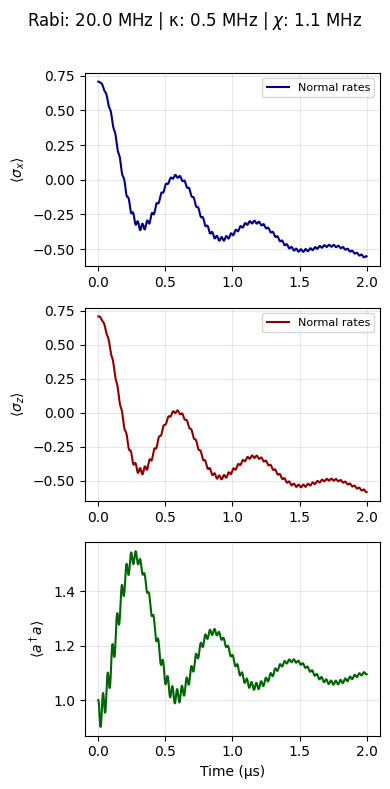

Dominant oscillation frequency: 1.498 MHz
Period: 0.667 μs
Peak height: 2.765e+01


/tmp/ipykernel_197881/2290969375.py:475: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend()


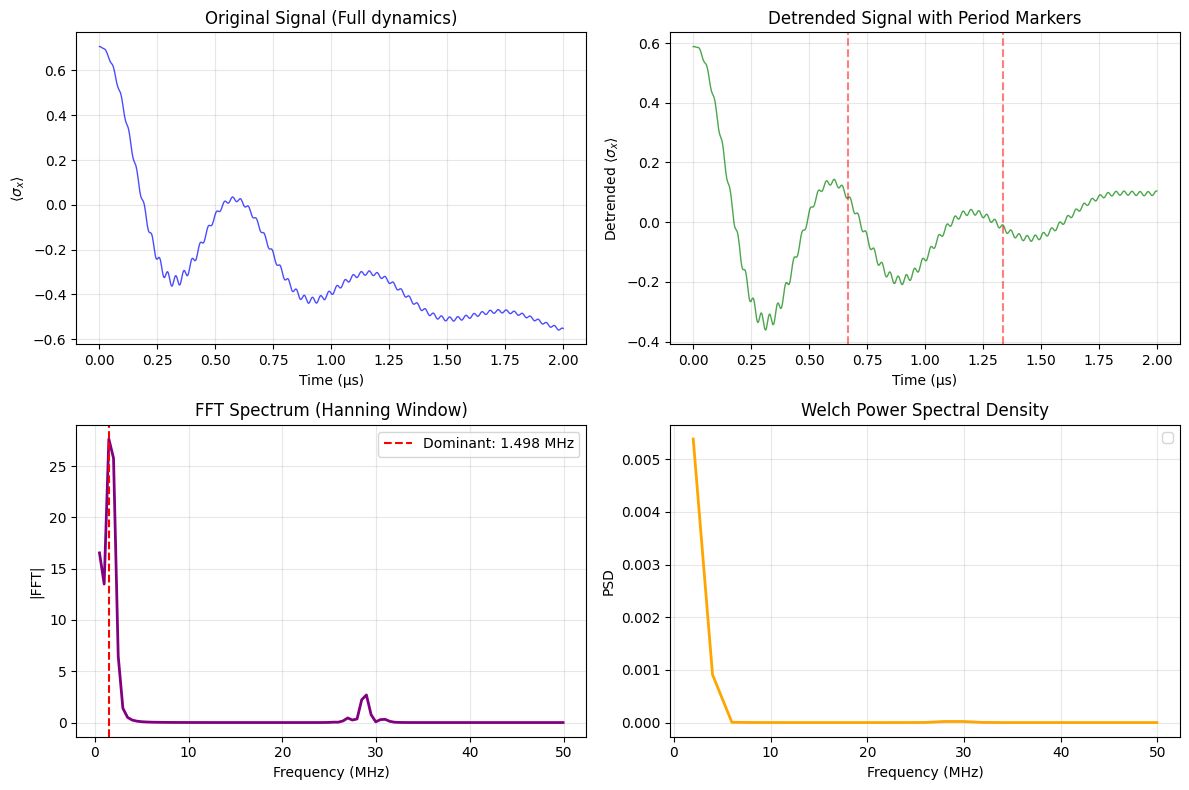

./diff_point/eff_coupling_1.0MHz_20251105_201147.pkl
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.0MHz_20251105_201147.pkl
Description: Full-dynamics for eff_coupling=1MHz
Timestamp: 20251105_201147


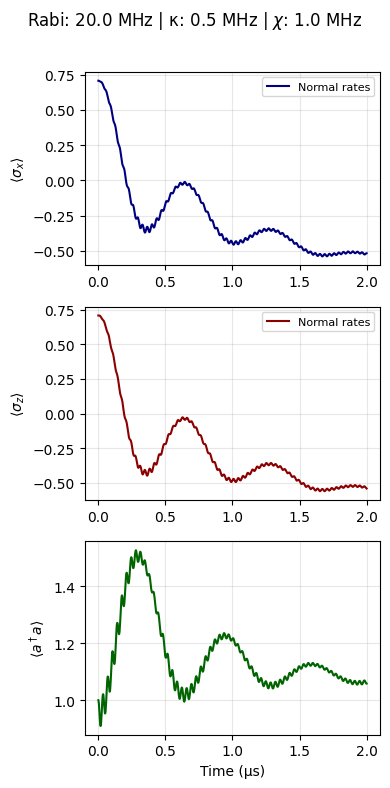

Dominant oscillation frequency: 1.498 MHz
Period: 0.667 μs
Peak height: 3.087e+01


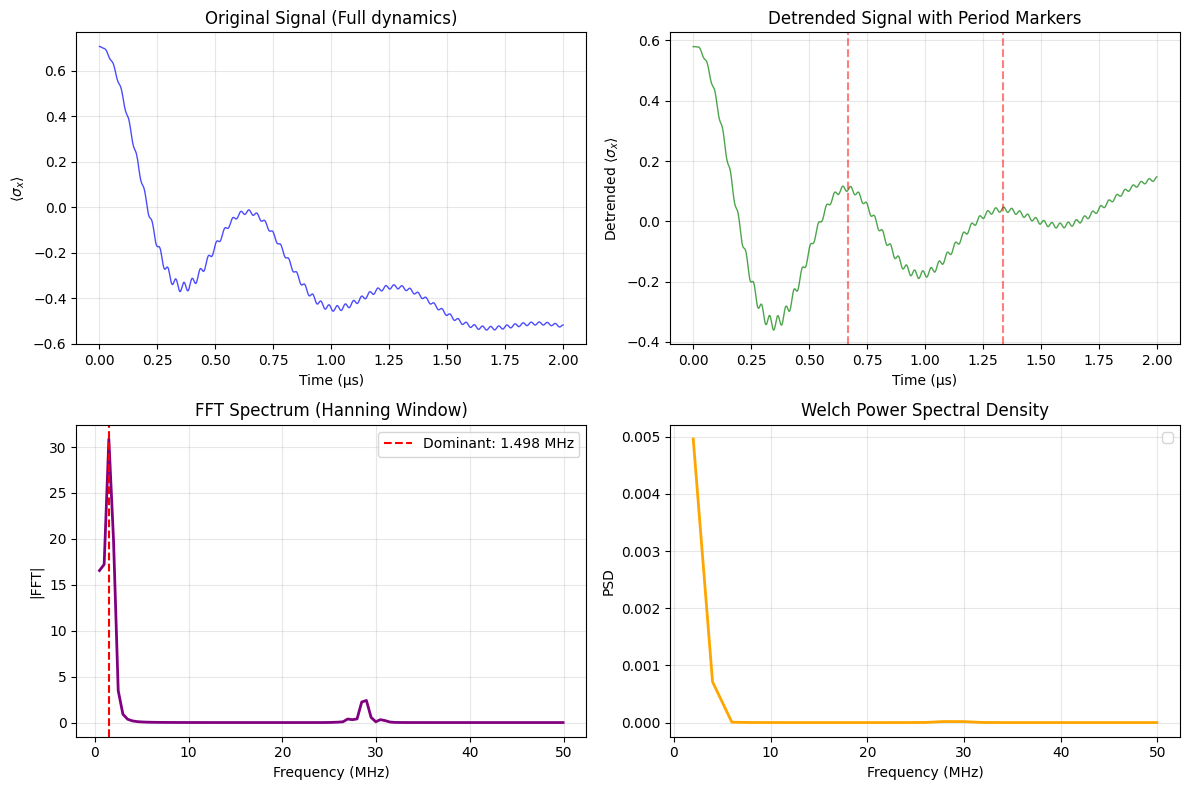

./diff_point/eff_coupling_1.2MHz_20251105_202726.pkl
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.2MHz_20251105_202726.pkl
Description: Full-dynamics for eff_coupling=1.2MHz
Timestamp: 20251105_202726


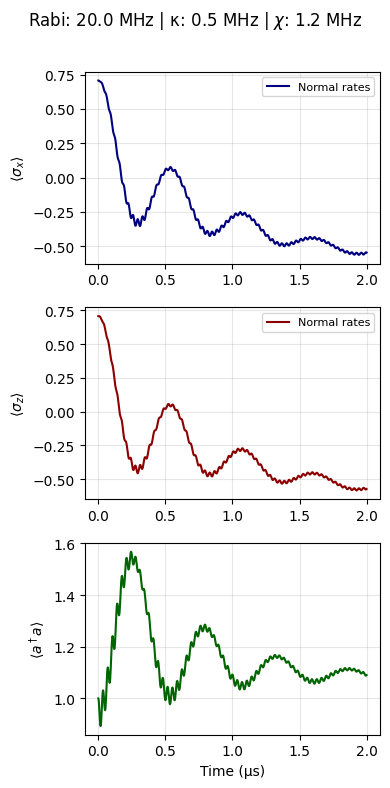

Dominant oscillation frequency: 1.998 MHz
Period: 0.501 μs
Peak height: 2.963e+01


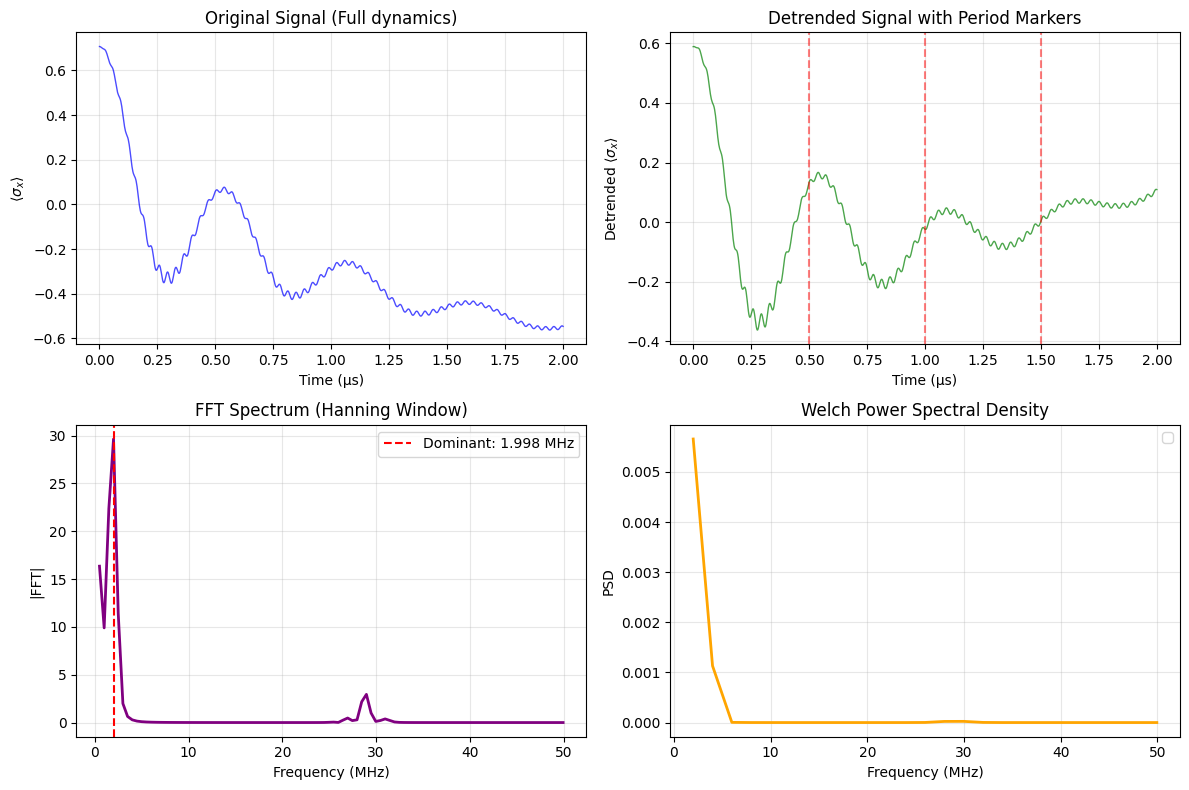

./diff_point/eff_coupling_1.3MHz_20251105_203515.pkl
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.3MHz_20251105_203515.pkl
Description: Full-dynamics for eff_coupling=1.3MHz
Timestamp: 20251105_203515


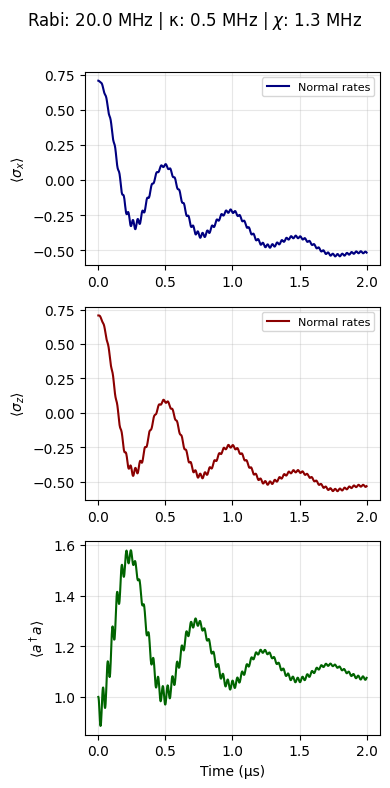

Dominant oscillation frequency: 1.998 MHz
Period: 0.501 μs
Peak height: 3.042e+01


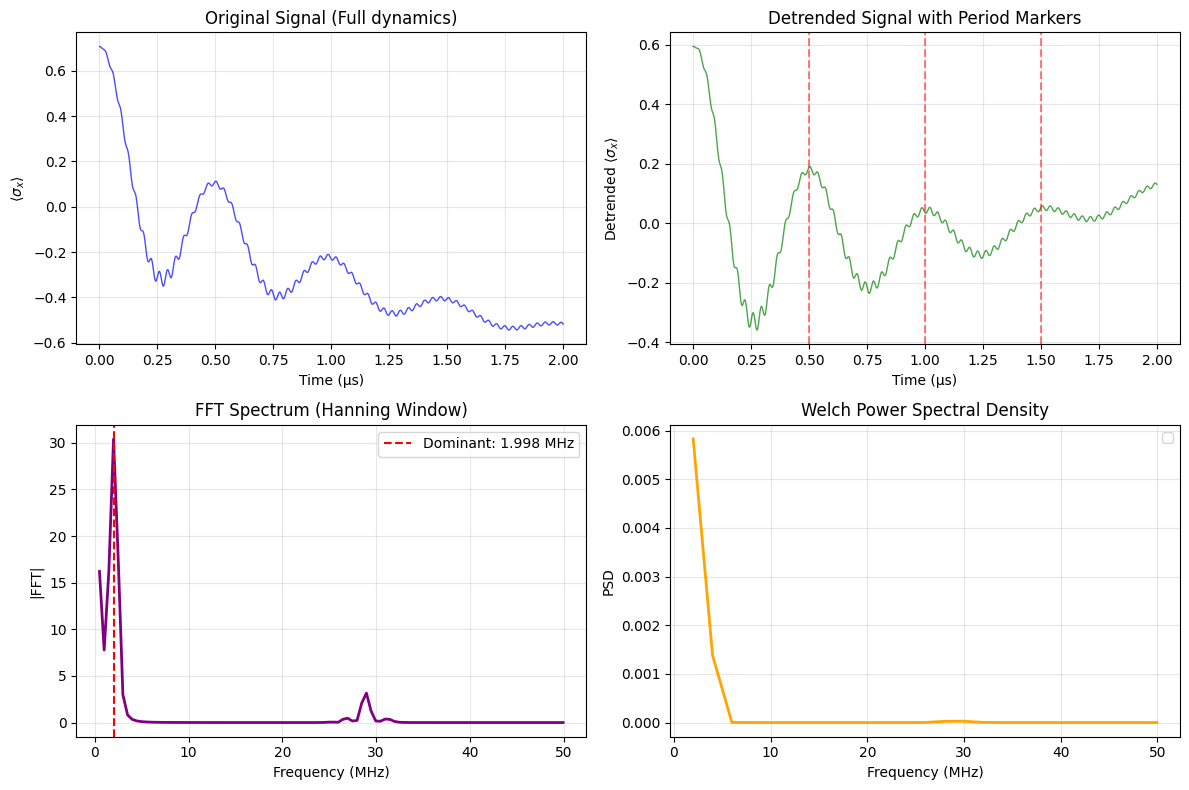

./diff_point/eff_coupling_1.4MHz_20251105_204306.pkl
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.4MHz_20251105_204306.pkl
Description: Full-dynamics for eff_coupling=1.4MHz
Timestamp: 20251105_204306


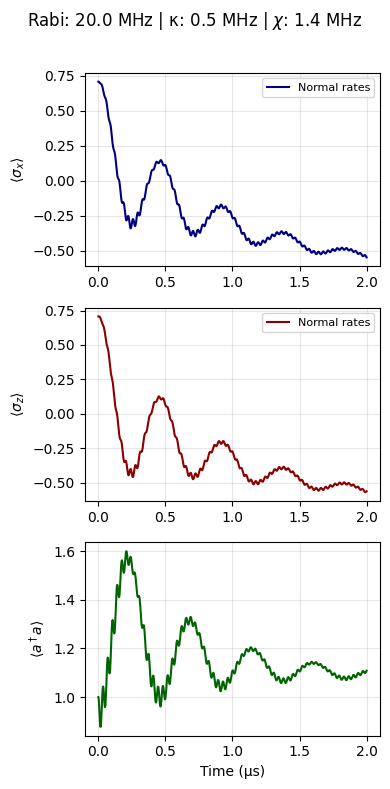

Dominant oscillation frequency: 1.998 MHz
Period: 0.501 μs
Peak height: 2.800e+01


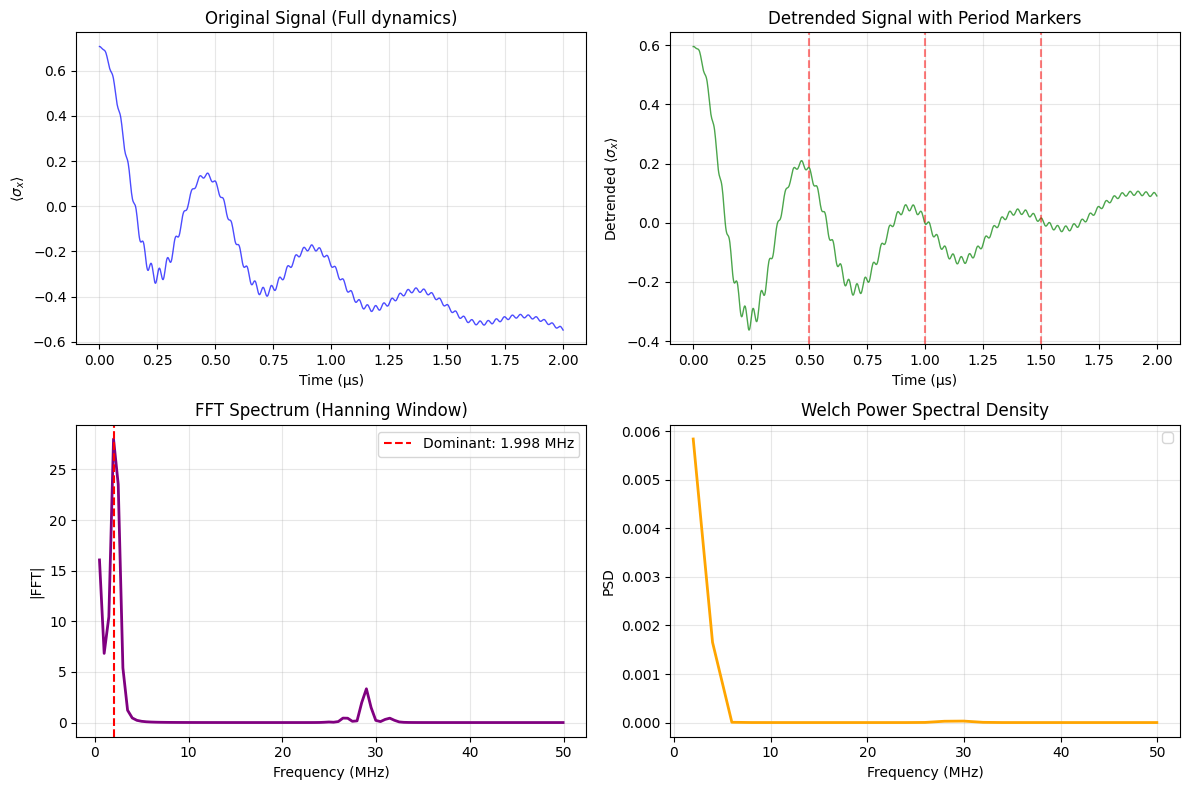

./diff_point/eff_coupling_1.6MHz_20251105_205847.pkl
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.6MHz_20251105_205847.pkl
Description: Full-dynamics for eff_coupling=1.6MHz
Timestamp: 20251105_205847


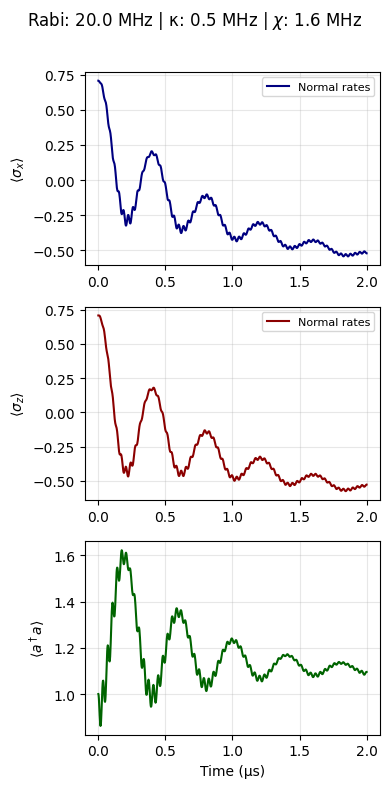

Dominant oscillation frequency: 2.497 MHz
Period: 0.400 μs
Peak height: 2.942e+01


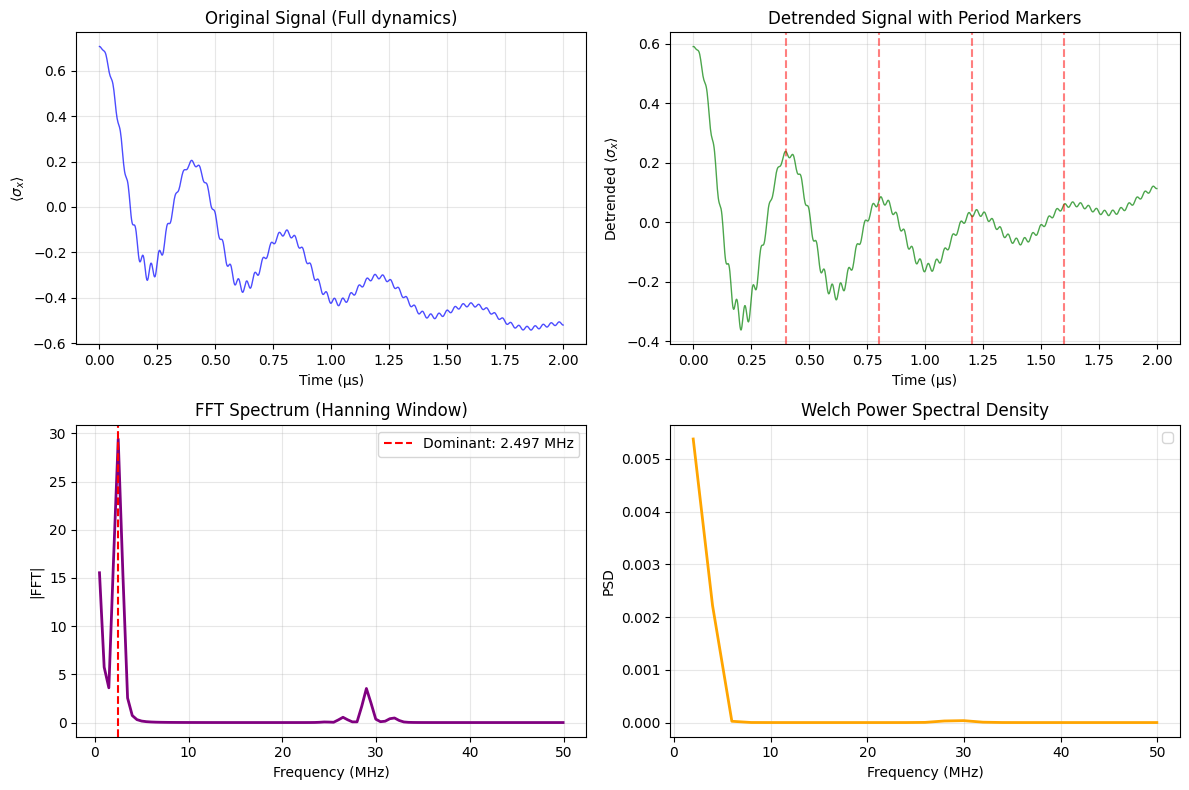

./diff_point/eff_coupling_1.7MHz_20251105_210636.pkl
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.7MHz_20251105_210636.pkl
Description: Full-dynamics for eff_coupling=1.7MHz
Timestamp: 20251105_210636


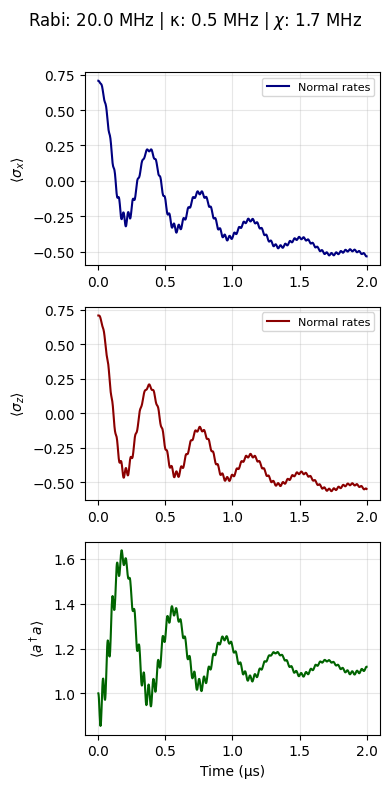

Dominant oscillation frequency: 2.497 MHz
Period: 0.400 μs
Peak height: 2.783e+01


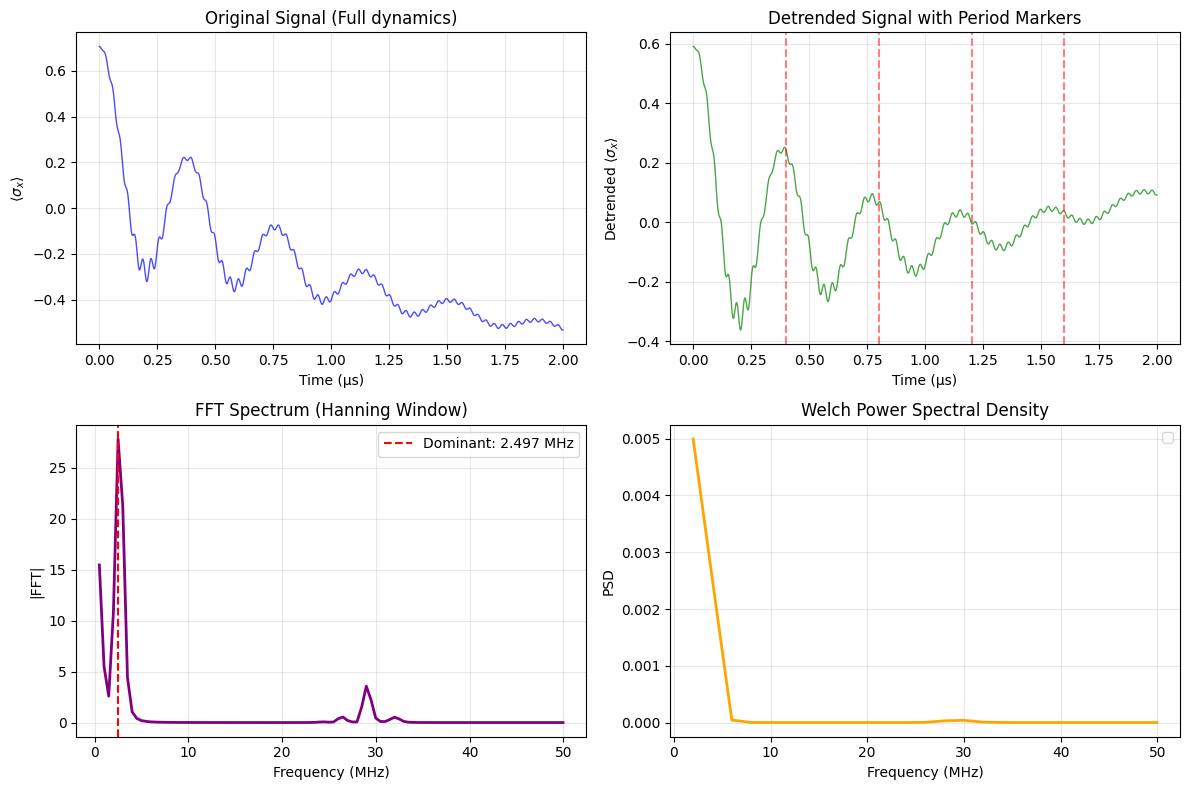

./diff_point/eff_coupling_1.5MHz_20251105_205056.pkl
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.5MHz_20251105_205056.pkl
Description: Full-dynamics for eff_coupling=1.5MHz
Timestamp: 20251105_205056


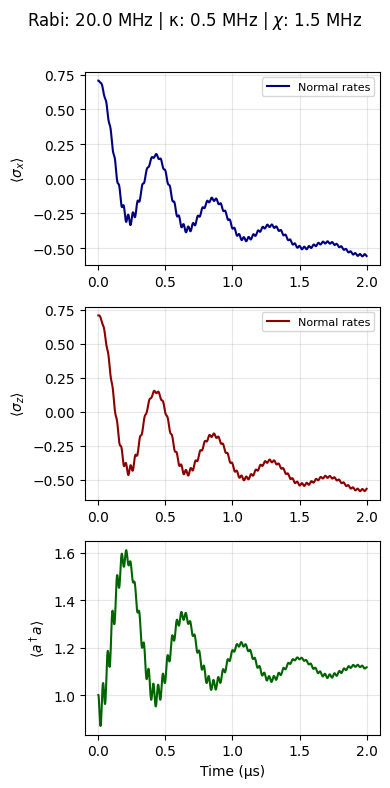

Dominant oscillation frequency: 2.497 MHz
Period: 0.400 μs
Peak height: 2.786e+01


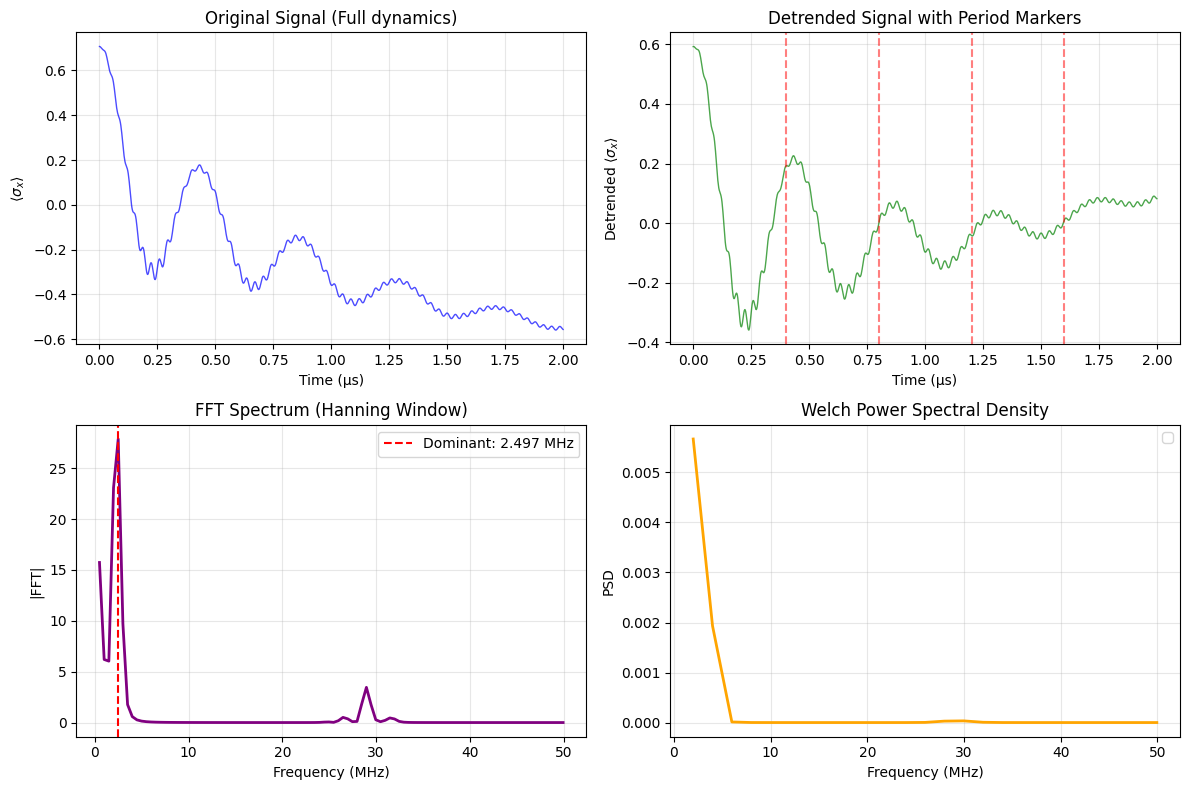

./diff_point/eff_coupling_1.8MHz_20251105_211426.pkl
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.8MHz_20251105_211426.pkl
Description: Full-dynamics for eff_coupling=1.8MHz
Timestamp: 20251105_211426


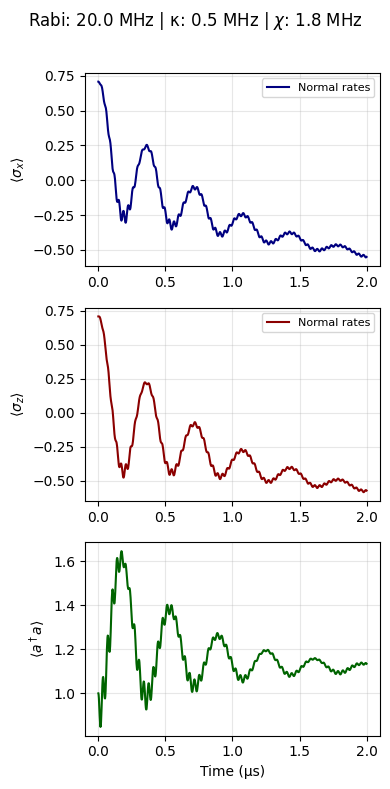

Dominant oscillation frequency: 2.997 MHz
Period: 0.334 μs
Peak height: 2.589e+01


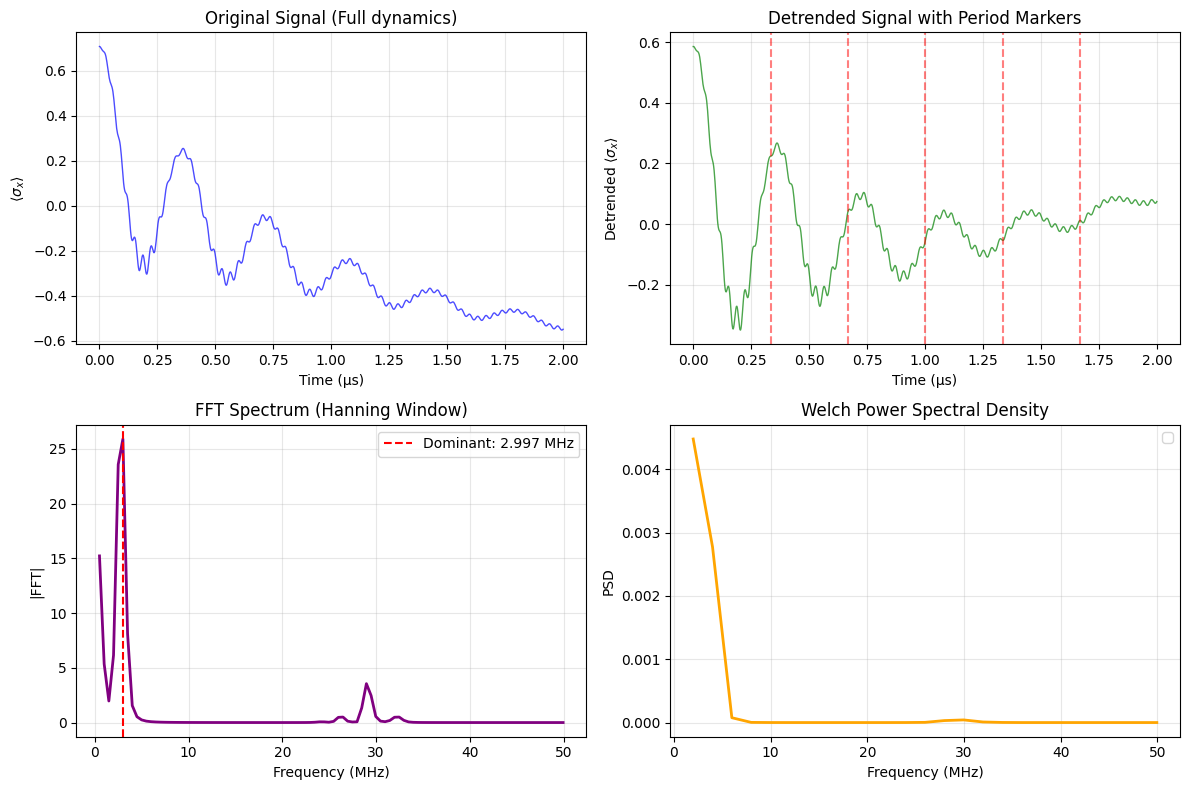

./diff_point/eff_coupling_1.9MHz_20251105_212216.pkl
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.9MHz_20251105_212216.pkl
Description: Full-dynamics for eff_coupling=1.9MHz
Timestamp: 20251105_212216


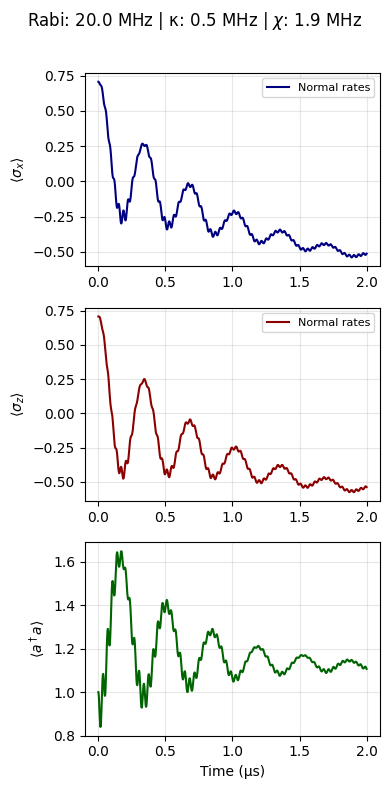

Dominant oscillation frequency: 2.997 MHz
Period: 0.334 μs
Peak height: 2.813e+01


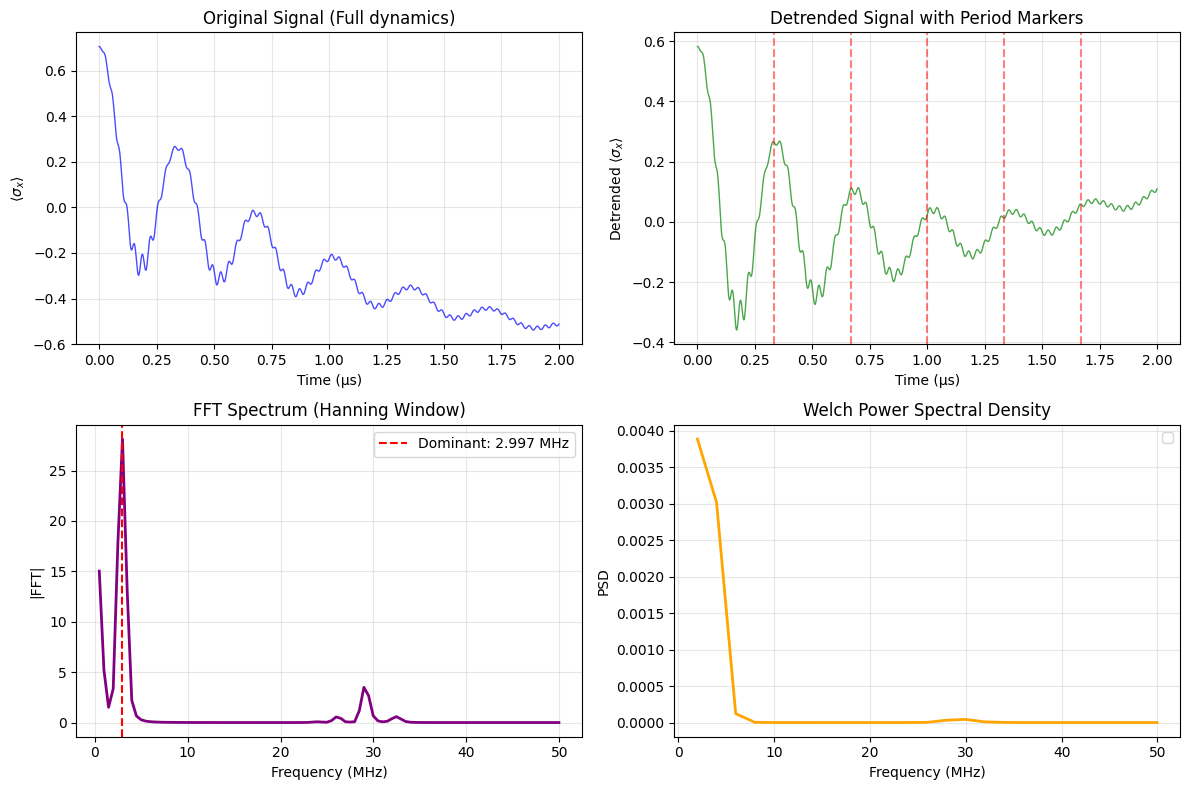

./diff_point/eff_coupling_2.0MHz_20251105_213005.pkl
Multi-dynamics loaded from: ./diff_point/eff_coupling_2.0MHz_20251105_213005.pkl
Description: Full-dynamics for eff_coupling=2MHz
Timestamp: 20251105_213005


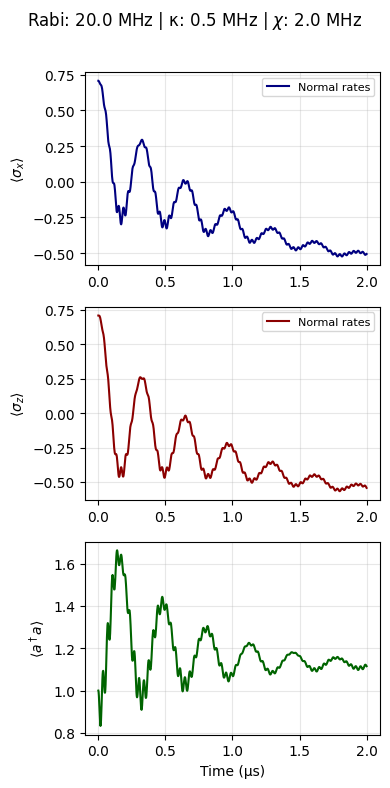

Dominant oscillation frequency: 2.997 MHz
Period: 0.334 μs
Peak height: 2.739e+01


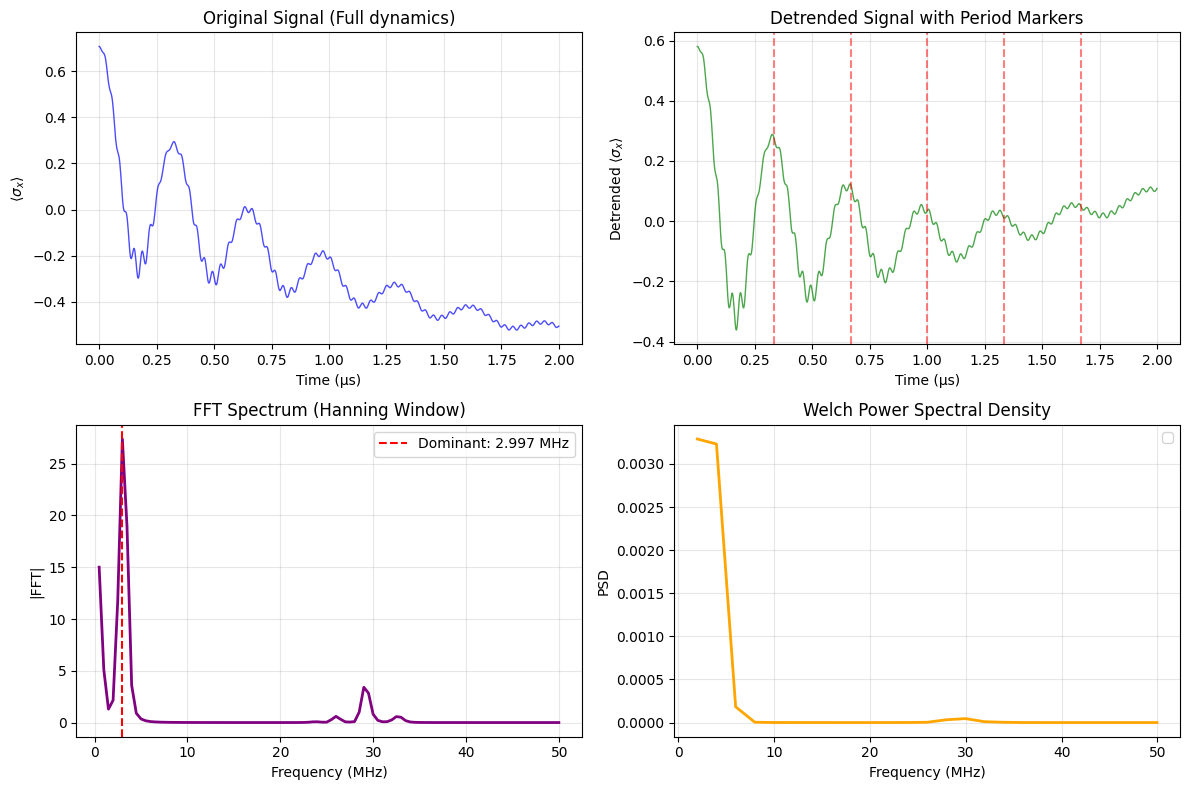

In [43]:
data_dir = "./diff_point"
save_dir = "./plots_kappa0_5"     
eff_couplings = []
dominant_freqs = []
periods = []

for file in os.listdir(data_dir):
    if file.endswith(".pkl"):
        filepath = os.path.join(data_dir, file)
        print(filepath)
        try:
            # ... [your existing loading code] ...
                        
            full_dynamics, parameters = load_all_dynamics(filepath)
            N = parameters['N']
            time_steps = parameters['time_steps']
            final_time__mus = parameters['final_time__mus']
            max_time = final_time__mus
            # Time axis (in microseconds)
            tlist = np.linspace(0, final_time__mus, time_steps)

            # For comparison: here you can add Redfield results if you have them loaded separately
            # e.g., redfield_dynamics = ...
            # For now, we'll just plot the saved full_dynamics (Lindblad) version
            dynamics_dict = {"Normal rates": full_dynamics}

            # Format parameters text for the title
            params_text = [
                f"Rabi: {parameters['rabi_freq']/(2*np.pi*1e6):.1f} MHz",
                f"κ: {parameters['cavity_diss_rate']/(2*np.pi*1e6):.1f} MHz",
                r"$\chi$: " + f"{parameters['eff_coupling']/(2*np.pi*1e6):.1f} MHz",
            ]

            # === Plot σ_x, σ_z, and photon number ===
            fig, axes = plt.subplots(3, 1, figsize=(4, 8))

            x_exp = expect(tensor(qeye(N), sigmax()), full_dynamics)
            z_exp = expect(tensor(qeye(N), sigmaz()), full_dynamics)
            cavity_number_op = tensor(destroy(N).dag() * destroy(N), qeye(2))
            cavity_exp = expect(cavity_number_op, full_dynamics)

            if max_time is None:
                max_time = final_time__mus
            mask = tlist <= max_time

            axes[0].plot(tlist[mask], x_exp[mask], color='navy', label='Normal rates')
            axes[0].set_ylabel(r'$\langle\sigma_x\rangle$')
            axes[0].legend(fontsize=8)
            axes[0].grid(alpha=0.3)

            axes[1].plot(tlist[mask], z_exp[mask], color='darkred', label='Normal rates')
            axes[1].set_ylabel(r'$\langle\sigma_z\rangle$')
            axes[1].legend(fontsize=8)
            axes[1].grid(alpha=0.3)

            axes[2].plot(tlist[mask], cavity_exp[mask], color='darkgreen', label='Photon number')
            axes[2].set_ylabel(r'$\langle a^\dagger a \rangle$')
            axes[2].set_xlabel("Time (μs)")
            axes[2].grid(alpha=0.3)

            plt.suptitle(" | ".join(params_text))
            plt.tight_layout(rect=[0, 0, 1, 0.97])

            # === Save figure ===
            os.makedirs(save_dir, exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            fig_name = f"comparison_plot_eff_coupling_{parameters['eff_coupling']:.1f}MHz__{timestamp}.png"
            fig_path = os.path.join(save_dir, fig_name)
            plt.show()

            plt.close(fig)
            # Improved analysis with frequency bounds
            dominant_freq, period = analyze_sigma_x_oscillations(
                tlist[mask], x_exp[mask],
                save_dir="./plots_fft_kappa0_5",
                label="Full dynamics",
                min_freq_MHz=0.01,  # Set reasonable bounds
                max_freq_MHz=50.0  # Based on your system parameters
            )
            
            # Only add if we found a valid frequency
            if dominant_freq > 0:
                eff_couplings.append(parameters['eff_coupling'])
                dominant_freqs.append(dominant_freq)
                periods.append(period)
                
        except Exception as e:
            print(f"✗ Failed to plot {file}: {e}")

In [82]:
(1/0.9)**2

1.234567901234568

Multi-dynamics loaded from: ./diff_point/eff_coupling_1.1MHz_20251105_201936.pkl
Description: Full-dynamics for eff_coupling=1.1MHz
Timestamp: 20251105_201936


125663706.14359173
111840698.46779664
0.7469970385734606
0.6648273643303799
0.89
1.0002942374912516


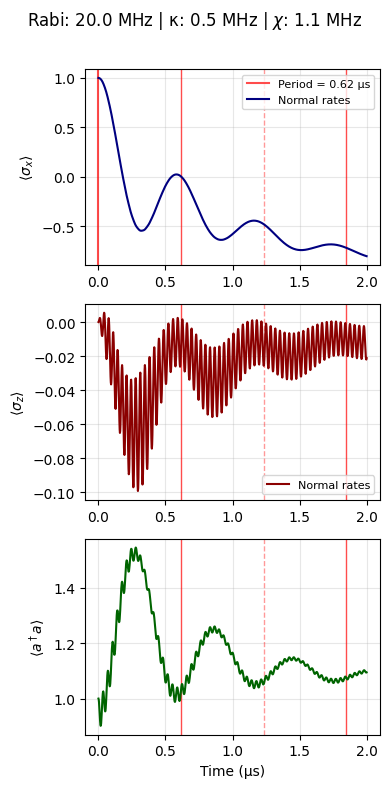

✓ Saved plot to: ./plots_kappa0_5/comparison_plot_eff_coupling_6911503.8MHz__20251106_144237.png
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.0MHz_20251105_201147.pkl
Description: Full-dynamics for eff_coupling=1MHz
Timestamp: 20251105_201147
125663706.14359173
113097335.52923256
0.7432941462471663
0.6689647316224497
0.9
1.000249477892851


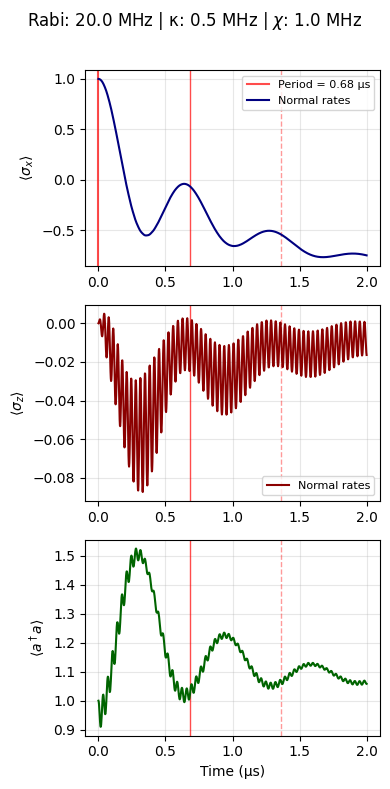

✓ Saved plot to: ./plots_kappa0_5/comparison_plot_eff_coupling_6283185.3MHz__20251106_144240.png
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.2MHz_20251105_202726.pkl
Description: Full-dynamics for eff_coupling=1.2MHz
Timestamp: 20251105_202726
125663706.14359173
110584061.40636073
0.7507135169227553
0.6606278948920248
0.88
1.000341091655037


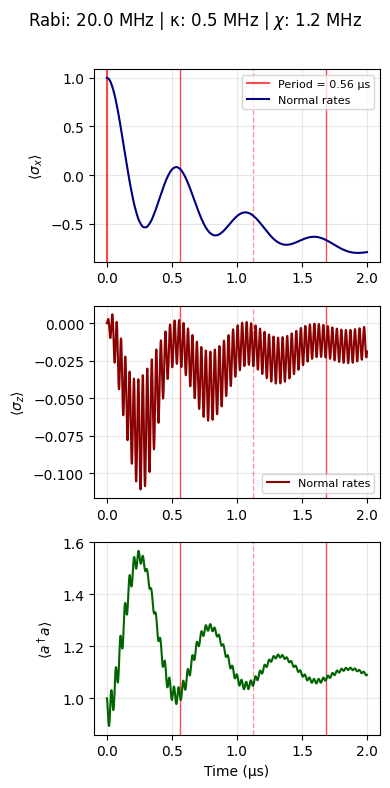

✓ Saved plot to: ./plots_kappa0_5/comparison_plot_eff_coupling_7539822.4MHz__20251106_144243.png
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.3MHz_20251105_203515.pkl
Description: Full-dynamics for eff_coupling=1.3MHz
Timestamp: 20251105_203515
125663706.14359173
109327424.34492481
0.7544430785777146
0.6563654783626117
0.87
1.0003896686502356


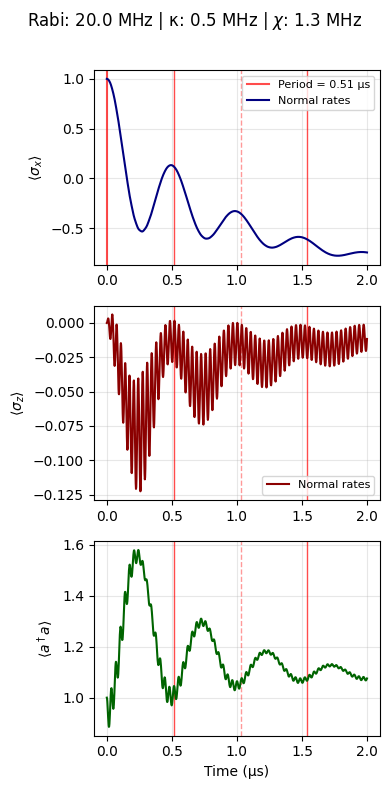

✓ Saved plot to: ./plots_kappa0_5/comparison_plot_eff_coupling_8168140.9MHz__20251106_144245.png
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.4MHz_20251105_204306.pkl
Description: Full-dynamics for eff_coupling=1.4MHz
Timestamp: 20251105_204306
125663706.14359173
108070787.28348888
0.758185196311683
0.6520392688280474
0.86
1.0004395997102442


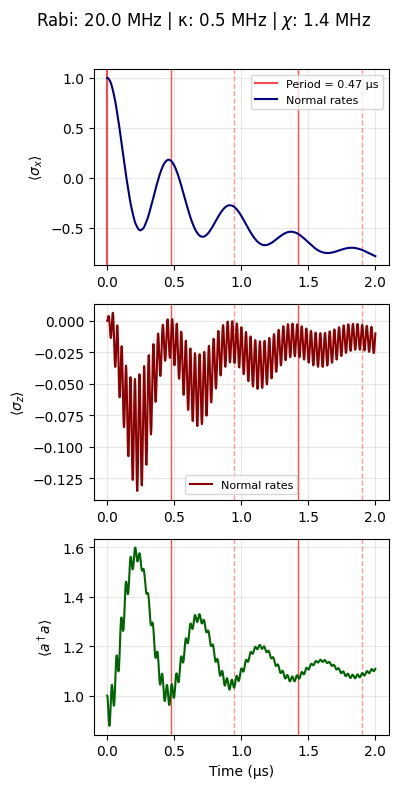

✓ Saved plot to: ./plots_kappa0_5/comparison_plot_eff_coupling_8796459.4MHz__20251106_144248.png
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.6MHz_20251105_205847.pkl
Description: Full-dynamics for eff_coupling=1.6MHz
Timestamp: 20251105_205847
125663706.14359173
105557513.16061707
0.765704864789611
0.6431920864232733
0.8400000000000001
1.0005420672766003


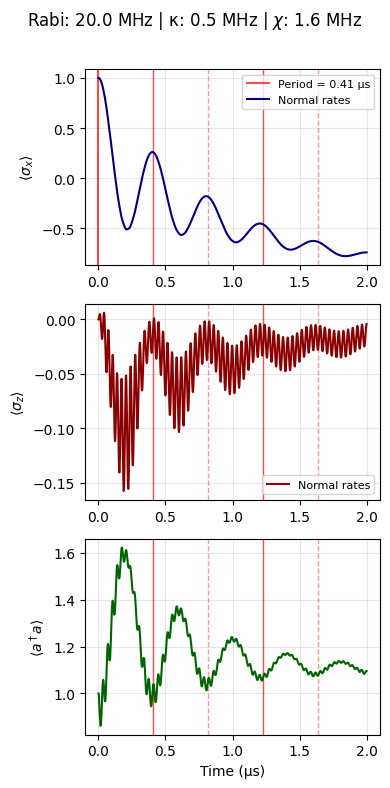

✓ Saved plot to: ./plots_kappa0_5/comparison_plot_eff_coupling_10053096.5MHz__20251106_144251.png
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.7MHz_20251105_210636.pkl
Description: Full-dynamics for eff_coupling=1.7MHz
Timestamp: 20251105_210636
125663706.14359173
104300876.09918113
0.7694812328797627
0.638669423290203
0.83
1.0005938864292394


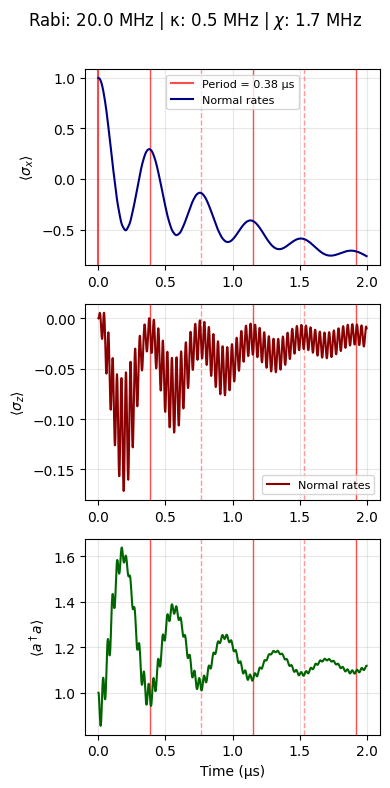

✓ Saved plot to: ./plots_kappa0_5/comparison_plot_eff_coupling_10681415.0MHz__20251106_144254.png
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.5MHz_20251105_205056.pkl
Description: Full-dynamics for eff_coupling=1.5MHz
Timestamp: 20251105_205056
125663706.14359173
106814150.22205298
0.7619393177594593
0.6476484200955405
0.8500000000000001
1.0004905196103637


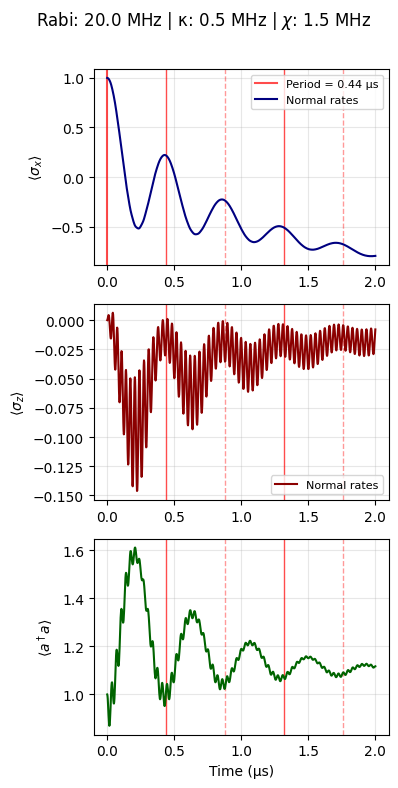

✓ Saved plot to: ./plots_kappa0_5/comparison_plot_eff_coupling_9424778.0MHz__20251106_144257.png
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.8MHz_20251105_211426.pkl
Description: Full-dynamics for eff_coupling=1.8MHz
Timestamp: 20251105_211426
125663706.14359173
103044239.03774524
0.7732677904963985
0.6340795882070469
0.8200000000000002
1.0006456262616066


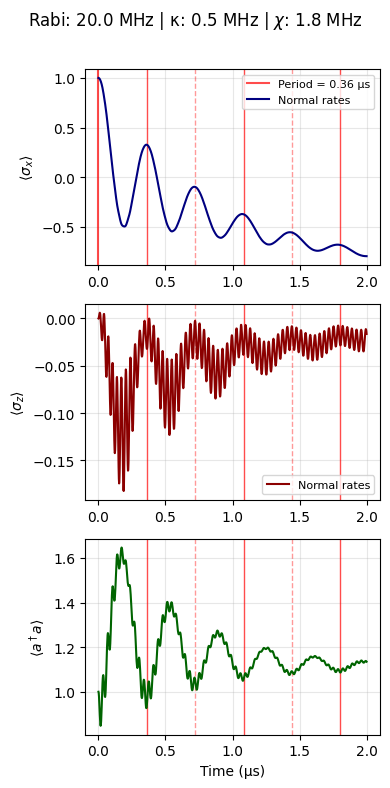

✓ Saved plot to: ./plots_kappa0_5/comparison_plot_eff_coupling_11309733.6MHz__20251106_144259.png
Multi-dynamics loaded from: ./diff_point/eff_coupling_1.9MHz_20251105_212216.pkl
Description: Full-dynamics for eff_coupling=1.9MHz
Timestamp: 20251105_212216
125663706.14359173
101787601.97630931
0.7770638784808231
0.6294217415694668
0.81
1.0006969421543388


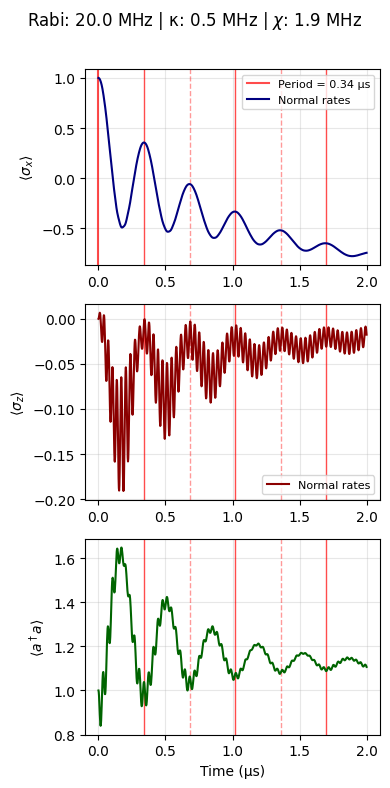

✓ Saved plot to: ./plots_kappa0_5/comparison_plot_eff_coupling_11938052.1MHz__20251106_144302.png
Multi-dynamics loaded from: ./diff_point/eff_coupling_2.0MHz_20251105_213005.pkl
Description: Full-dynamics for eff_coupling=2MHz
Timestamp: 20251105_213005
125663706.14359173
100530964.91487339
0.7808688094430303
0.6246950475544242
0.8
1.0007474964253789


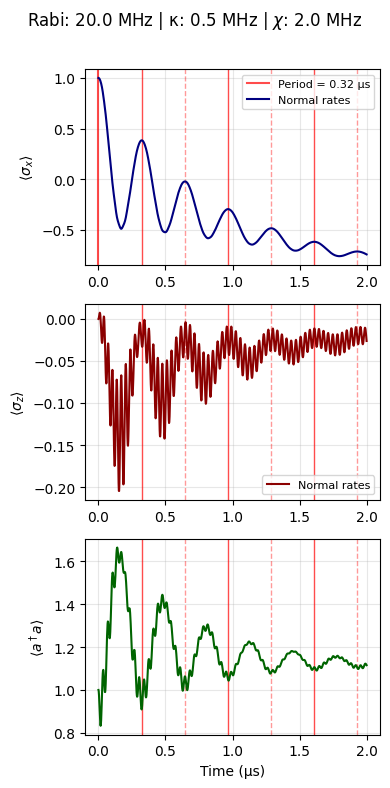

✓ Saved plot to: ./plots_kappa0_5/comparison_plot_eff_coupling_12566370.6MHz__20251106_144304.png


In [93]:
data_dir = "./diff_point"
save_dir = "./plots_kappa0_5"

eff_couplings = []
dominant_freqs = []

for file in os.listdir(data_dir):
    if file.endswith(".pkl"):
        filepath = os.path.join(data_dir, file)
        try:
            
            
            full_dynamics, parameters = load_all_dynamics(filepath)
            N = parameters['N']
            time_steps = parameters['time_steps']
            final_time__mus = parameters['final_time__mus']
            max_time = final_time__mus
            # Time axis (in microseconds)
            tlist = np.linspace(0, final_time__mus, time_steps)

            # For comparison: here you can add Redfield results if you have them loaded separately
            # e.g., redfield_dynamics = ...
            # For now, we'll just plot the saved full_dynamics (Lindblad) version
            dynamics_dict = {"Normal rates": full_dynamics}

            # Format parameters text for the title
            params_text = [
                f"Rabi: {parameters['rabi_freq']/(2*np.pi*1e6):.1f} MHz",
                f"κ: {parameters['cavity_diss_rate']/(2*np.pi*1e6):.1f} MHz",
                r"$\chi$: " + f"{parameters['eff_coupling']/(2*np.pi*1e6):.1f} MHz",
            ]

            # === Plot σ_x, σ_z, and photon number ===
            fig, axes = plt.subplots(3, 1, figsize=(4, 8))

            U = unitary_diag_qubit_hamiltonian(parameters)

            x_exp = expect(tensor(qeye(N), U*sigmax()*U.dag()), full_dynamics)
            z_exp = expect(tensor(qeye(N), U*sigmaz()*U.dag()), full_dynamics)
            cavity_number_op = tensor(destroy(N).dag() * destroy(N), qeye(2))
            cavity_exp = expect(cavity_number_op, full_dynamics)

            rabi_freq = parameters['rabi_freq']
            qubit_targetz = parameters['qubit_targetz']
            eff_coupling = parameters['eff_coupling']
            cavity_diss_rate = parameters['cavity_diss_rate']
            input_power = parameters['input_power']
            cavity_photon_number = 10**(input_power/10)
            qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
            qubit_detuning_lamb_shift_ss = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
            cavity_detuning = -(qubit_detuning_lamb_shift_ss**2 + rabi_freq**2)**.5
            cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
            
            print(qubit_targetz)
            qubit_detuning_lamb_shift = qubit_detuning + eff_coupling
            omega_diag = ( qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
            lon_coupling = eff_coupling*qubit_detuning/omega_diag

            cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + lon_coupling) + .5j*cavity_diss_rate)
            cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - lon_coupling) + .5j*cavity_diss_rate)
            qubit_dissipation_rate = 2*eff_coupling*np.imag(cavity_field_g*np.conj(cavity_field_e))

            #qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*np.real(cavity_field_g*np.conj(cavity_field_e)) + 1)
            qubit_targetz = qubit_detuning_lamb_shift
            omega_diag = (rabi_freq**2 + qubit_targetz**2)**.5
            transversal_coupling = rabi_freq*eff_coupling/omega_diag
            print(qubit_targetz)
            print(rabi_freq/omega_diag)
            print(qubit_targetz/omega_diag)
            print(qubit_targetz/rabi_freq)
            print(np.real(cavity_field_g*np.conj(cavity_field_e))**.5)
            if max_time is None:
                max_time = final_time__mus
            mask = tlist <= max_time
            omega = 1e-6*np.abs(cavity_diss_rate**2 - 16*transversal_coupling**2)**.5/(2*2*np.pi)
            Period = 1/omega
            if Period > 0 and Period < np.inf:
                # Calculate how many periods fit in the plot range
                max_periods = int(max_time / Period) + 1
                
                for n in range(1, max_periods + 1):
                    period_time = n * Period
                    
                    # Only plot if within the visible range
                    if period_time <= max_time:
                        # Different line styles for different multiples
                        if n % 2 == 0:
                            linestyle = '--'
                            alpha = 0.4
                        else:
                            linestyle = '-'
                            alpha = 0.7
                        
                        # Add to all subplots
                        for ax in axes:
                            ax.axvline(period_time, color='red', linestyle=linestyle, 
                                    alpha=alpha, linewidth=1)
                
                # Add legend entry for period lines (only once)
                axes[0].axvline(0, color='red', linestyle='-', alpha=0.7, 
                            label=f'Period = {Period:.2f} μs')

            axes[0].plot(tlist[mask], x_exp[mask], color='navy', label='Normal rates')

            axes[0].set_ylabel(r'$\langle\sigma_x\rangle$')
            axes[0].legend(fontsize=8)
            axes[0].grid(alpha=0.3)

            axes[1].plot(tlist[mask], z_exp[mask], color='darkred', label='Normal rates')
            axes[1].set_ylabel(r'$\langle\sigma_z\rangle$')
            axes[1].legend(fontsize=8)
            axes[1].grid(alpha=0.3)

            axes[2].plot(tlist[mask], cavity_exp[mask], color='darkgreen', label='Photon number')
            axes[2].set_ylabel(r'$\langle a^\dagger a \rangle$')
            axes[2].set_xlabel("Time (μs)")
            axes[2].grid(alpha=0.3)

            plt.suptitle(" | ".join(params_text))
            plt.tight_layout(rect=[0, 0, 1, 0.97])

            # === Save figure ===
            os.makedirs(save_dir, exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            fig_name = f"comparison_plot_eff_coupling_{parameters['eff_coupling']:.1f}MHz__{timestamp}.png"
            fig_path = os.path.join(save_dir, fig_name)
            plt.show()

            print(f"✓ Saved plot to: {fig_path}")
            plt.close(fig)

        except Exception as e:
            print(f"✗ Failed to plot {file}: {e}")



# Load data
    

In [17]:
np.array(eff_couplings)/(2*np.pi), dominant_freqs

(array([1000000., 1100000., 1200000., 1400000., 1300000., 1500000.,
        1800000., 1900000., 1700000., 1600000., 2000000.]),
 [np.float64(1.9979999999999998),
  np.float64(1.9979999999999998),
  np.float64(2.4974999999999996),
  np.float64(2.997),
  np.float64(2.4974999999999996),
  np.float64(2.997),
  np.float64(3.4964999999999997),
  np.float64(3.9959999999999996),
  np.float64(3.4964999999999997),
  np.float64(2.997),
  np.float64(3.9959999999999996)])

In [ ]:
eff_couplings_corr = np.array([eff_couplings[0],eff_couplings[5], eff_couplings[-1]])
dominant_freqs_corr = np.array([dominant_freqs[0], dominant_freqs[5], dominant_freqs[-1]])
cavity_diss_rate = parameters['cavity_diss_rate']

np.abs(cavity_diss_rate**2 - 16*eff_couplings_corr**2)**.5/2, (2*(2*np.pi)*dominant_freqs_corr*1e6)**2

(array([-6.21785077e+14, -1.41135343e+15, -2.51674912e+15]),
 array([6.30392004e+14, 1.41838201e+15, 2.52156802e+15]))